https://www.analyticsvidhya.com/blog/2020/11/attention-mechanism-for-caption-generation

# 1. Imports

In [1]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings

warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

# from keras.layers.merge import add
from keras.layers import add
from keras.callbacks import ModelCheckpoint

# from keras.preprocessing.image import load_img, img_to_array
from keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

print(tf.config.list_physical_devices("GPU"))

2023-01-07 00:23:42.526063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-07 00:23:43.092514: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jj/miniconda3/envs/tf/lib/:/home/jj/miniconda3/envs/tf/lib/:/home/jj/miniconda3/envs/tf/lib/:/home/jj/miniconda3/envs/tf/lib/
2023-01-07 00:23:43.092589: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PAT

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-07 00:23:43.852026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-07 00:23:43.856512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-07 00:23:43.856730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.


# 2. Data Loading and Preprocessing

In [2]:
image_path = "dataset/Flicker8k_Dataset"
dir_Flickr_text = "dataset/Flicker8k_text/Flickr8k.token.indo.txt"
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 16182


### Create Dataframe to store image id and captions for ease of use

In [3]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,seorang anak berbaju merah muda sedang menaiki...
1,1,1000268201_693b08cb0e.jpg,seorang gadis pergi ke sebuah bangunan kayu.
2,2,1000268201_693b08cb0e.jpg,seorang gadis kecil memanjat ke sebuah rumah b...
3,3,1000268201_693b08cb0e.jpg,seorang gadis kecil menaiki tangga ke rumah be...
4,4,1000268201_693b08cb0e.jpg,seorang gadis kecil berbaju merah muda masuk k...


### Visualize a few images and their 5 captions

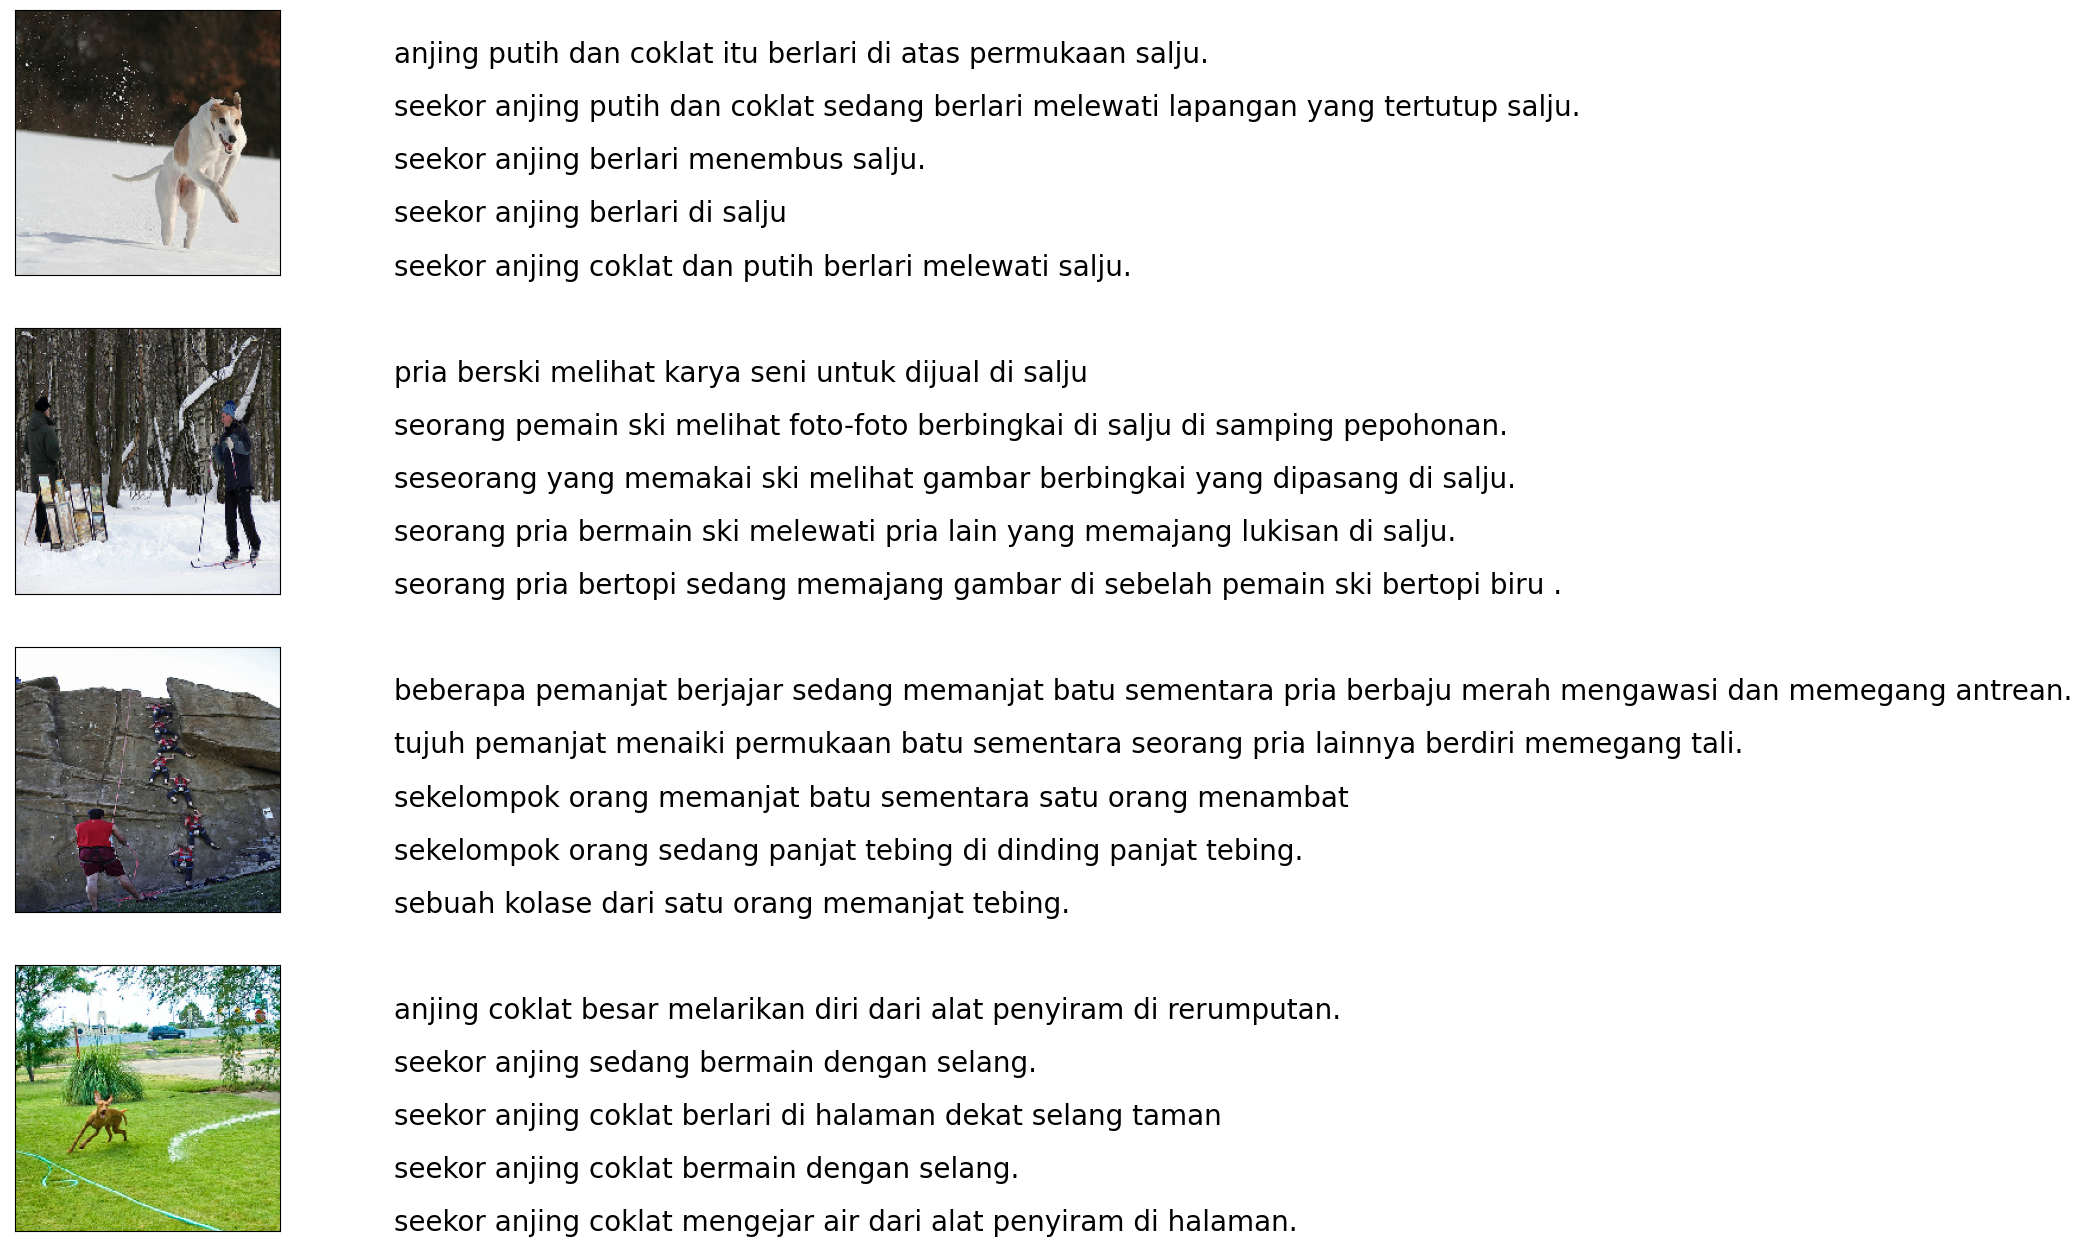

In [4]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

### Check current vocab size

In [5]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 9798


### Perform some text cleaning (e.g. removing punctuation, single characters, and numeric values

In [6]:
def remove_punctuation(text_original):
   # Add whitespace padding to punctuation
   text_padding = re.sub(r"([^\w\s])", r" \1 ", text_original)
   # Delete spaces at the beginning or end of string
   text_padding = text_padding.strip()
   text_no_punctuation = text_padding.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
         if len(word) > 1:
            text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
         isalpha = word.isalpha()
         if isalpha:
            text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 6495


### Save all caption and image paths in 2 lists to be loaded at once using the path set. Add 'start' and 'end' tags to every caption for the model

In [7]:
PATH = "dataset/Flicker8k_Dataset/"
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  seorang anak berbaju merah muda sedang menaiki tangga di jalan masuk <end>',
 '<start>  seorang gadis pergi ke sebuah bangunan kayu <end>',
 '<start>  seorang gadis kecil memanjat ke sebuah rumah bermain kayu <end>',
 '<start>  seorang gadis kecil menaiki tangga ke rumah bermainnya <end>',
 '<start>  seorang gadis kecil berbaju merah muda masuk ke sebuah pondok kayu <end>',
 '<start>  seekor anjing hitam dan anjing berbintik sedang berkelahi <end>',
 '<start>  seekor anjing hitam dan anjing tiga warna bermain satu sama lain di jalan <end>',
 '<start>  seekor anjing hitam dan seekor anjing putih dengan bintik bintik coklat saling menatap di jalan <end>',
 '<start>  dua anjing dari ras yang berbeda saling memandang di jalan <end>',
 '<start>  dua anjing di trotoar bergerak ke arah satu sama lain <end>']

In [8]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

### Check total image paths and captions

In [9]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


### Take only 40000 of each to be able to select batch size properly (e.g. 625 batches if batch size = 64)

In [10]:
def data_limiter(num,all_captions,all_img_name_vector):
    train_captions, img_name_vector = shuffle(all_captions,all_img_name_vector,random_state=1)
    train_captions = train_captions[:num]
    img_name_vector = img_name_vector[:num]
    return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

# 2. Model Definition

### Define the image feature extraction model with VGG16.To only extract an image vector from images, remove the softmax layer from model. Preprocess all images to same size (i.e. 224x224)

In [11]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

2023-01-07 00:23:51.899975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-07 00:23:51.901230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-07 00:23:51.901460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-07 00:23:51.901673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_nod

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Map each image name to the function to load images

In [12]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

### Extract features and store them to their respective .npy files. Then pass those features through the encoder (.npy stores all info required to reconstruct an array, including dtype and shape info)

In [13]:
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

  0%|                                                                                                                                                                                                                                                | 0/127 [00:00<?, ?it/s]2023-01-07 00:23:53.765366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-01-07 00:23:54.853332: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-07 00:23:55.984578: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-07 00:23:55.984637: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. Th

### Tokenize captions and build vocabulary of all unique words in the data. Then limit the vocab size to the top 5000 words to save memory. Replace words not in vocab with the 'unk' token

In [14]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
)

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index["<pad>"] = 0
tokenizer.index_word[0] = "<pad>"

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding="post")


### Visualize the padded training and captions and the tokenized vectors

In [15]:
train_captions[:3]

['<start>  beberapa anak melompat ke tumpukan daun di tanah <end>',
 '<start>  seorang pria yang mendaki di hutan belantara mengacungkan jempol ke kamera <end>',
 '<start>  seekor anjing putih berlari melalui air ke pantai <end>']

In [16]:
train_seqs[:3]

[[2, 78, 11, 32, 22, 387, 405, 4, 75, 3],
 [2, 5, 10, 14, 246, 4, 127, 2137, 956, 1114, 22, 85, 3],
 [2, 12, 6, 20, 27, 97, 25, 22, 58, 3]]

### Calculate the max and min length of all captions

In [17]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)


max_length = calc_max_length(train_seqs)


def calc_min_length(tensor):
    return min(len(t) for t in tensor)


min_length = calc_min_length(train_seqs)

print("Max Length of any caption : Min Length of any caption = " + str(max_length) + " : " + str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 3


### Create training and validation sets (80:20 split)

In [18]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, cap_vector, test_size=0.2, random_state=0)

### Define traning parameters

In [19]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

### Create tf.data dataset to use for training

In [20]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode("utf-8") + ".npy")
    return img_tensor, cap


dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(
    lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Define encoder-decoder architecture with Attention. VGG-16 Encoder defined below

In [21]:
class VGG16_Encoder(tf.keras.Model):
    # This encoder passes the features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(VGG16_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        # x= self.dropout(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### Define RNN based on GPU/CPU capabilities

In [22]:
def rnn_type(units):
    if tf.test.is_gpu_available():
        print("Using GPU")
        return tf.compat.v1.keras.layers.CuDNNLSTM(
            units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )
    else:
        print("Using CPU")
        return tf.keras.layers.GRU(
            units,
            return_sequences=True,
            return_state=True,
            recurrent_activation="sigmoid",
            recurrent_initializer="glorot_uniform",
        )

print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


2023-01-07 00:24:53.780116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-07 00:24:53.780370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-07 00:24:53.780578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-07 00:24:53.780922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-07 00:24:53.780934: I tensorflow/core/co

### Define RNN Decoder with Bahdanau Attention

In [23]:
"""The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder."""


class Rnn_Local_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Rnn_Local_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )

        self.fc1 = tf.keras.layers.Dense(self.units)

        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
        self.batchnormalization = tf.keras.layers.BatchNormalization(
            axis=-1,
            momentum=0.99,
            epsilon=0.001,
            center=True,
            scale=True,
            beta_initializer="zeros",
            gamma_initializer="ones",
            moving_mean_initializer="zeros",
            moving_variance_initializer="ones",
            beta_regularizer=None,
            gamma_regularizer=None,
            beta_constraint=None,
            gamma_constraint=None,
        )

        self.fc2 = tf.keras.layers.Dense(vocab_size)

        # Implementing Attention Mechanism
        self.Uattn = tf.keras.layers.Dense(units)
        self.Wattn = tf.keras.layers.Dense(units)
        self.Vattn = tf.keras.layers.Dense(1)

    def call(self, x, features, hidden):
        # features shape ==> (64,49,256) ==> Output from ENCODER
        # hidden shape == (batch_size, hidden_size) ==>(64,512)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (64, 49, 1)
        # Attention Function
        """e(ij) = f(s(t-1),h(j))"""
        """ e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))"""

        score = self.Vattn(
            tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))
        )

        # self.Uattn(features) : (64,49,512)
        # self.Wattn(hidden_with_time_axis) : (64,1,512)
        # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
        # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

        # you get 1 at the last axis because you are applying score to self.Vattn
        # Then find Probability using Softmax
        """attention_weights(alpha(ij)) = softmax(e(ij))"""

        attention_weights = tf.nn.softmax(score, axis=1)

        # attention_weights shape == (64, 49, 1)
        # Give weights to the different pixels in the image
        """ C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) """

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
        # context_vector shape after sum == (64, 256)
        # x shape after passing through embedding == (64, 1, 256)

        x = self.embedding(x)
        # x shape after concatenation == (64, 1,  512)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # passing the concatenated vector to the GRU

        output, state = self.gru(x)
        # shape == (batch_size, max_length, hidden_size)

        x = self.fc1(output)
        # x shape == (batch_size * max_length, hidden_size)

        x = tf.reshape(x, (-1, x.shape[2]))

        # Adding Dropout and BatchNorm Layers
        x = self.dropout(x)
        x = self.batchnormalization(x)

        # output shape == (64 * 512)
        x = self.fc2(x)

        # shape : (64 * 8329(vocab))
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

### Define loss func and optimizers

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# 4. Model Training

### Use a technique called Teacher Forcing (where target word is passed as the next input to the decoder) (helps to learn the correct sequence or corect statistical properties for the sequence quickly)

In [25]:
loss_plot = []


@tf.function
def train_step(img_tensor, target):
    loss = 0
    # initializing the hidden state for each batch
    # because the captions are not related from image to image

    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

### Train the model

In [26]:
start_epoch = 0
EPOCHS = 20
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print(
                "Epoch {} Batch {} Loss {:.4f}".format(
                    epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])
                )
            )
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print("Epoch {} Loss {:.6f}".format(epoch + 1, total_loss / num_steps))

    print("Time taken for 1 epoch {} sec\n".format(time.time() - start))

2023-01-07 00:25:20.713745: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1b75c610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-07 00:25:20.713782: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-01-07 00:25:20.736354: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-07 00:25:21.038246: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-07 00:25:21.075968: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1 Batch 0 Loss 2.8663
Epoch 1 Batch 100 Loss 1.6172
Epoch 1 Batch 200 Loss 1.3109
Epoch 1 Batch 300 Loss 1.1604
Epoch 1 Batch 400 Loss 1.0144
Epoch 1 Loss 1.355887
Time taken for 1 epoch 107.34607982635498 sec

Epoch 2 Batch 0 Loss 0.9532
Epoch 2 Batch 100 Loss 1.0634
Epoch 2 Batch 200 Loss 1.0999
Epoch 2 Batch 300 Loss 1.0636
Epoch 2 Batch 400 Loss 0.8819
Epoch 2 Loss 1.017184
Time taken for 1 epoch 73.60901308059692 sec

Epoch 3 Batch 0 Loss 0.9176
Epoch 3 Batch 100 Loss 0.9292
Epoch 3 Batch 200 Loss 0.9727
Epoch 3 Batch 300 Loss 0.8309
Epoch 3 Batch 400 Loss 0.7636
Epoch 3 Loss 0.906922
Time taken for 1 epoch 72.61461281776428 sec

Epoch 4 Batch 0 Loss 0.7675
Epoch 4 Batch 100 Loss 0.8919
Epoch 4 Batch 200 Loss 0.8455
Epoch 4 Batch 300 Loss 0.8268
Epoch 4 Batch 400 Loss 0.8198
Epoch 4 Loss 0.829277
Time taken for 1 epoch 71.64043188095093 sec

Epoch 5 Batch 0 Loss 0.7982
Epoch 5 Batch 100 Loss 0.8307
Epoch 5 Batch 200 Loss 0.7993
Epoch 5 Batch 300 Loss 0.6833
Epoch 5 Batch 400

### Plot the error graph

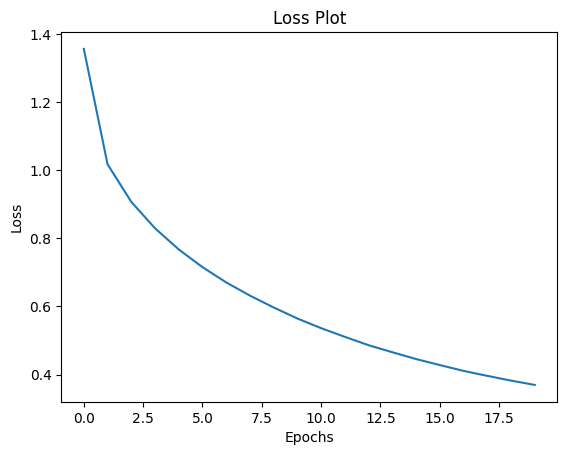

In [27]:
plt.plot(loss_plot)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.show()

# 5. Greedy Search and BLEU Evaluation

### Define greedy method of defining captions

In [28]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])
    )

    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == "<end>":
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[: len(result), :]

    return result, attention_plot

### Define a function to plot the attention maps for each word generated

In [29]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result // 2, len_result // 2, l + 1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap="gray", alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

### Generate a caption for the image at the start

BLEU score: 77.77777777777779
Real Caption: [['Dua', 'anjing', 'putih', 'sedang', 'bermain', 'di', 'salju'], ['Dua', 'anjing', 'putih', 'seperti', 'serak', 'berada', 'di', 'luar', 'di', 'atas', 'salju'], ['dua', 'samoyad', 'bermain', 'di', 'salju'], ['Dua', 'anjing', 'putih', 'berlari', 'dan', 'bermain', 'di', 'lapangan', 'yang', 'tertutup', 'salju'], ['Dua', 'anjing', 'berbulu', 'putih', 'bermain', 'di', 'salju']]
Prediction Caption: ['dua', 'anjing', 'putih', 'sedang', 'bermain', 'bersama', 'di', 'lapangan', 'bersalju']


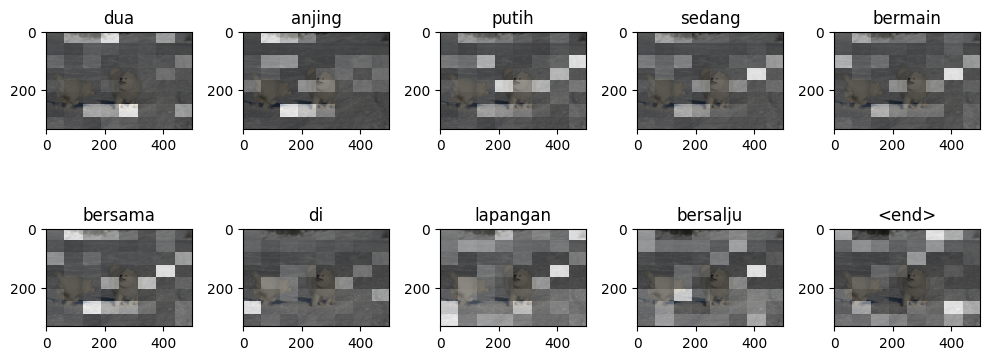

In [83]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = "dataset/Flicker8k_Dataset/2319175397_3e586cfaf8.jpg"

result, attention_plot = evaluate(image)

real_caption = [["Dua anjing putih sedang bermain di salju"], ["Dua anjing putih seperti serak berada di luar di atas salju"], ["dua samoyad bermain di salju"], ["Dua anjing putih berlari dan bermain di lapangan yang tertutup salju"], ["Dua anjing berbulu putih bermain di salju"]]
count = 0
for i in real_caption:
    for sentence in i:
        sentence = sentence.split()
        real_caption[count] = sentence
        count += 1

# remove "<unk>" in result
for i in result:
    if i == "<unk>":
        result.remove(i)

for i in real_caption:
    if i == "<unk>":
        real_caption.remove(i)

# remove <end> from result
result_join = " ".join(result)
result_final = result_join.rsplit(" ", 1)[0]
result_final = result_final.split()

# real_appn = []
# real_appn.append(real_caption.split())
# reference = real_appn
reference = real_caption
candidate = result_final

# print(reference)
# print(candidate)
score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(f"BLEU score: {score * 100}")

print("Real Caption:", real_caption)
print("Prediction Caption:", result_final)
plot_attention(image, result, attention_plot)

### Generate captions from other images

In [86]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = " ".join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# Remove <start> and <end> from real caption
first = real_caption.split(" ", 1)[1]
real_caption = first.rsplit(" ", 1)[0]
print(real_caption)


# # remove "<unk>" in result
# for i in result:
#     if i == "<unk>":
#         result.remove(i)

# # remove <end> from result
# result_join = " ".join(result)
# result_final = result_join.rsplit(" ", 1)[0]

# real_appn = []
# real_appn.append(real_caption.split())
# reference = real_appn
# candidate = result_final

# print(reference)
# print(candidate)
# score = sentence_bleu(reference, candidate)
# print(f"BLEU score: {score * 100}")

# print("Real Caption:", real_caption)
# print("Prediction Caption:", result_final)

# plot_attention(image, result, attention_plot)
# print(f"time took to Predict: {round(time.time() - start)} sec")

# Image.open(img_name_val[rid])

dua pengendara motor berbaju hitam hijau yang pertama mendorong sepedanya yang kedua mengendarai sepedanya


BLEU score: 2.2898201241324607e-76
Real Caption: seorang wanita dengan pakaian olahraga berwarna hijau mencoba memukul bola tenis dengan raket
Prediction Caption: seorang gadis muda memukul bola tenis


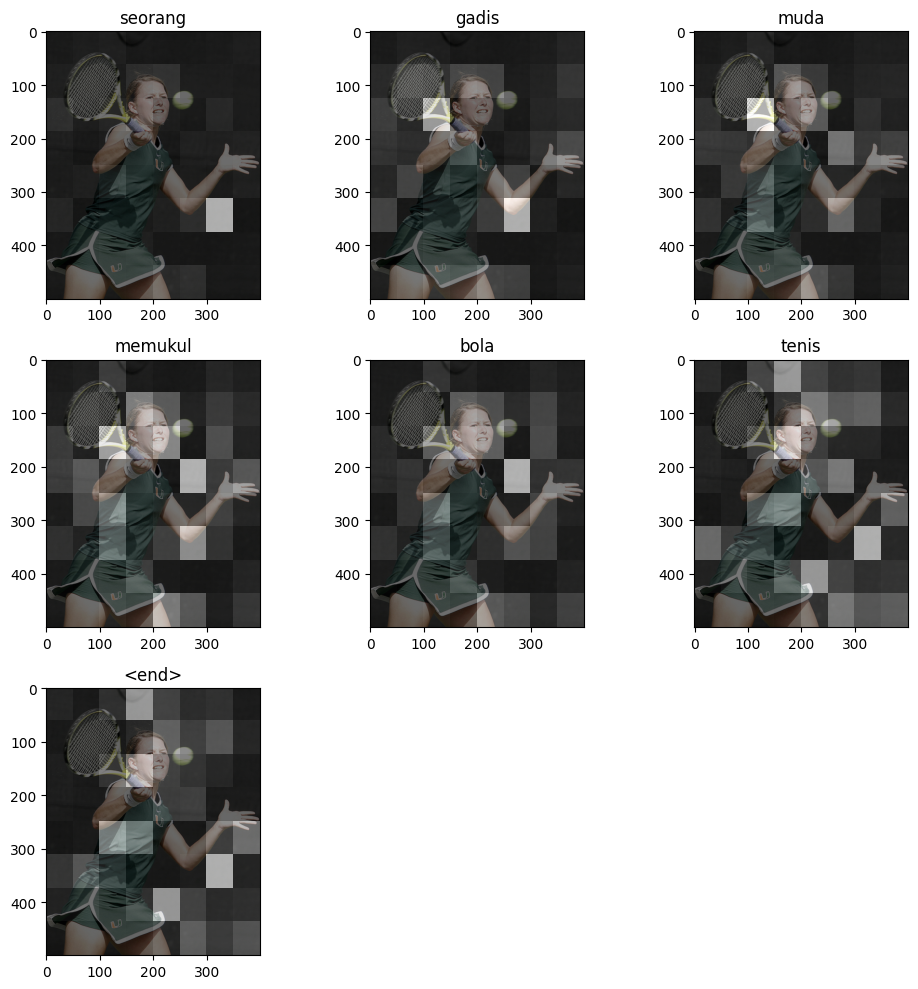

In [34]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = " ".join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(" ", 1)[1]
real_caption = first.rsplit(" ", 1)[0]

# remove "<unk>" in result
for i in result:
    if i == "<unk>":
        result.remove(i)

for i in real_caption:
    if i == "<unk>":
        real_caption.remove(i)

# remove <end> from result
result_join = " ".join(result)
result_final = result_join.rsplit(" ", 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BLEU score: {score * 100}")

print("Real Caption:", real_caption)
print("Prediction Caption:", result_final)

plot_attention(image, result, attention_plot)